# Further feature engineering

Running this notebook requires lightgbm and mlxtend to be installed.

In [1]:
# importing functions
%run helper_functions.ipynb

### Prior transformation of data
* Adding calculated values (calculated in Data preparation.ipynb)
* Engineering new features from spacegroup
* Filling missing values
* Applying log-transformation to some features *("cAlGa", "cAlIn", "cGaAl", "cInAl", "cInGa", "distAlO", "distGaAl", "distGaIn", "distGaO", "distInAl", "distInGa", "distInO", "spacegroup")*
* Standardizing

These are done in helper_functions.ipynb

### Setting baseline

#### Formation energy

In [2]:
from lightgbm import LGBMRegressor
params_fe = {
    "boosting_type": "gbdt",
    "max_depth": 4,
    "learning_rate": 0.07,
    "n_estimators":90,
    "num_leaves": 15}
lgbm_fe = LGBMRegressor(**params_fe)
print("CV score:", evaluate_CV(lgbm_fe, X_full, y_fe))
print("CV score with log-transformation on target:",evaluate_CV(lgbm_fe, X_full, np.log1p(y_fe), metric=rmsle_scorer_exp))

CV score: 0.03063770639495525
CV score with log-transformation on target: 0.03067388533613983


#### Bandgap energy

In [3]:
params_be = {"boosting_type": "gbdt",
         "max_depth": 5,
         "learning_rate": 0.12,
         "n_estimators":100,
         "num_leaves": 20}
lgbm_be = LGBMRegressor(**params_be)
print("CV score:", evaluate_CV(lgbm_be, X_full, y_be))
print("CV score with log-transformation on target:", evaluate_CV(lgbm_be, X_full, np.log1p(y_be), metric=rmsle_scorer_exp))

CV score: 0.08652825493907336
CV score with log-transformation on target: 0.08626319311731868


In [4]:
# for submitting to Kaggle
#lgbm_be.fit(X_full, np.log1p(y_be))
#lgbm_fe.fit(X_full, np.log1p(y_fe))
#save_results(np.expm1(lgbm_fe.predict(X_full_test)), np.expm1(lgbm_be.predict(X_full_test)), "baseline")

Baseline kaggle private score: 0.06645

### Using PCA

Here I will test if using PCA will give any benefit.

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
cols =['lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang']
pca.fit(X_full[cols])
X_full["pca_lattice_vector"] = pca.transform(X_full[cols])
pca.fit(X_full_test[cols])
X_full_test["pca_lattice_vector"] = pca.transform(X_full_test[cols])

In [6]:
pca = PCA(n_components=1)
cols=['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
pca.fit(X_full[cols])
X_full["pca_lattice_angle"] = pca.transform(X_full[cols])
X_full_test["pca_lattice_angle"] = pca.transform(X_full_test[cols])

In [7]:
pca = PCA(n_components=1)
cols=['distAlGa','distAlIn', 'distAlO', 'distGaAl', 'distGaIn', 'distGaO', 'distInAl','distInGa', 'distInO']
pca.fit(X_full[cols])
X_full["pca_c_el"] = pca.transform(X_full[cols])
X_full_test["pca_c_el"] = pca.transform(X_full_test[cols])

In [8]:
from lightgbm import LGBMRegressor
params_fe = {
    "boosting_type": "gbdt",
    "max_depth": 4,
    "learning_rate": 0.07,
    "n_estimators":90,
    "num_leaves": 15}
lgbm_fe = LGBMRegressor(**params_fe)
print("CV score:",evaluate_CV(lgbm_fe, X_full, y_fe))
print("CV score with log-transformation on target:", evaluate_CV(lgbm_fe, X_full, np.log1p(y_fe), metric=rmsle_scorer_exp))

CV score: 0.030211969787901728
CV score with log-transformation on target: 0.030485969276569446


In [9]:
params_be = {"boosting_type": "gbdt",
         "max_depth": 5,
         "learning_rate": 0.12,
         "n_estimators":100,
         "num_leaves": 20}
lgbm_be = LGBMRegressor(**params_be)
print("CV score:",evaluate_CV(lgbm_be, X_full, y_be))
print("CV score with log-transformation on target:",evaluate_CV(lgbm_be, X_full, np.log1p(y_be), metric=rmsle_scorer_exp))

CV score: 0.08639266895047162
CV score with log-transformation on target: 0.08552706058401505


### Dropping columns

Testing if dropping any columns will give a better score.

In [10]:
lgbm_be = LGBMRegressor(**params_be)
baseline = evaluate_CV(lgbm_be, X_full, y_be) 
print("baseline:", baseline)
for col in X_full.columns:
    new_score = evaluate_CV(lgbm_be, X_full.drop(col,axis=1), y_be)
    if baseline > new_score:
        print(col, new_score)

baseline: 0.08639266895047162
number_of_total_atoms 0.08602563750126518
percent_atom_al 0.08575569154662085
percent_atom_in 0.0863257818025154
lattice_vector_1_ang 0.08562369197922594
lattice_vector_2_ang 0.08558426456169058
lattice_vector_3_ang 0.08633343297594909
lattice_angle_alpha_degree 0.08604188785988934
cAlAl 0.08502142098864722
cAlGa 0.08579877209913324
cAlIn 0.08604349355260768
cAlO 0.08637511851915505
cGaAl 0.0857408966282995
cGaIn 0.08557128223396028
cGaO 0.08625754044373726
cInIn 0.08541019321765204
cInO 0.0863532990038598
distAlAl 0.08551791559975859
distGaGa 0.08616658448915483
distInIn 0.08600330002563036
qAl 0.08625762457633203
qGa 0.08563125125815801
qO 0.08585620289255688
xEq 0.0860439295173042
centroSym 0.08630882342844616
pca_lattice_vector 0.08601167378886712
pca_c_el 0.08583396003602237


In [11]:
lgbm_be = LGBMRegressor(**params_be)
cols_to_drop = ["pca_lattice_vector", "cAlIn"]
print(evaluate_CV(lgbm_be, X_full.drop(cols_to_drop, axis=1), y_be))
print(evaluate_CV(lgbm_be, X_full.drop(cols_to_drop, axis=1), np.log1p(y_be), metric=rmsle_scorer_exp))

0.08614692938856561
0.08534471191544954


In [12]:
lgbm_fe = LGBMRegressor(**params_fe)
baseline = evaluate_CV(lgbm_fe, X_full, y_fe) 
print("baseline:", baseline)
for col in X_full.columns:
    new_score = evaluate_CV(lgbm_fe, X_full.drop(col,axis=1), y_fe)
    if baseline > new_score:
        print(col, new_score)

baseline: 0.030211969787901728
percent_atom_al 0.0302072306701917
lattice_angle_beta_degree 0.030164963888679654
lattice_angle_gamma_degree 0.030190009568097163
Vatom 0.030004156245694392
cAlIn 0.030174836091060496
cGaGa 0.030201113709556006
cGaIn 0.030177571343190705
cInAl 0.030016644020729278
distGaGa 0.03018846289205309


In [13]:
lgbm_fe = LGBMRegressor(**params_fe)
cols_to_drop = ["cAlIn", "cInAl"]
print(evaluate_CV(lgbm_fe, X_full.drop(cols_to_drop, axis=1), y_fe))
print(evaluate_CV(lgbm_fe, X_full.drop(cols_to_drop, axis=1), np.log1p(y_fe), metric=rmsle_scorer_exp))

0.029818649156244985
0.029756252049120663


In [14]:
X_full_be = X_full.drop(["cAlIn"], axis=1)
X_full_fe = X_full.drop(["cAlIn", "cInAl"], axis=1)
X_full_test_be = X_full_test.drop(["cAlIn"], axis=1)
X_full_test_fe = X_full_test.drop(["cAlIn", "cInAl"], axis=1)

In [15]:
# saving results for kaggle
#lgbm_be.fit(X_full_be, np.log1p(y_be))
#lgbm_fe.fit(X_full_fe, np.log1p(y_fe))
#save_results(np.expm1(lgbm_fe.predict(X_full_test_fe)), np.expm1(lgbm_be.predict(X_full_test_be)), "removal + pca")

Kaggle private score without pca: 0.06631

Kaggle private score with pca: 0.06681

**We can conclude that PCA didn't help us achieve better results for the test dataset. Dropping certain columns will be beneficial.**

# Training a stacked model

## Reloading the dataset before continuing

In [16]:
# reset features
%run helper_functions.ipynb
useless_cols = ['cAlAl', 'cInIn', 'cGaGa', 'distAlAl', 'distInIn', 'distGaGa']
X_full.drop(useless_cols, axis=1, inplace=True)
X_full_test.drop(useless_cols, axis=1, inplace=True)
X_full_be = X_full.drop(["cAlIn"], axis=1)
X_full_fe = X_full.drop(["cAlIn", "cInAl"], axis=1)
X_full_test_be = X_full_test.drop(["cAlIn"], axis=1)
X_full_test_fe = X_full_test.drop(["cAlIn", "cInAl"], axis=1)


## Parameter tuning

Tuning some additional models for the 2-level regressor.

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
def param_search(model, grid, fe=True, transform_target=True):
    gs = GridSearchCV(model, grid, n_jobs=-1, scoring=(rmsle_scorer_exp if transform_target else rmsle_scorer), cv=3)
    target = (y_fe if fe else y_be)
    gs.fit(X_full_fe if fe else X_full_be , np.log1p(target) if transform_target else target)
    print(f"best score: {gs.best_score_}")
    print(f"best params: {gs.best_params_}")
    return gs.best_params_
    

In [20]:

model = Ridge()
grid = {
    "alpha":[0.0001,0.005,0.01,0.05,0.1,0.5,1,1.5,2,2.5],
    "random_state": [3]
}

ridge_params_be = param_search(model, grid, fe=False, transform_target=True)

ridge_params_fe = param_search(model, grid, fe=True, transform_target=True)


best score: -0.09343253434423777
best params: {'alpha': 0.0001, 'random_state': 3}
best score: -0.04665305684703571
best params: {'alpha': 0.0001, 'random_state': 3}


In [21]:
model = ExtraTreesRegressor()
grid = {
    "n_estimators":[100,150,200,250],
    "max_depth":[None,10,12,15],
    "bootstrap":[True, False],
    "random_state": [3]
}

et_params_be = param_search(model, grid, fe=False, transform_target=True)
et_params_fe = param_search(model, grid, fe=True, transform_target=True)

best score: -0.0877859389811997
best params: {'bootstrap': True, 'max_depth': 12, 'n_estimators': 200, 'random_state': 3}
best score: -0.028986765224560233
best params: {'bootstrap': True, 'max_depth': 12, 'n_estimators': 250, 'random_state': 3}


In [22]:
# without the added parameters
et_params_fe={'bootstrap': True, 'max_depth': None, 'n_estimators': 250, 'random_state': 3}
et_fe = ExtraTreesRegressor(**et_params_fe)
params_be = {"boosting_type": "gbdt","max_depth": 5,"learning_rate": 0.12,"n_estimators":100,"num_leaves": 20}
lgbm_be = LGBMRegressor(**params_be)

# This is for kaggle
#lgbm_be.fit(X_full_be, np.log1p(y_be))
#et_fe.fit(X_full_fe, np.log1p(y_fe))
# save_results(np.expm1(et_fe.predict(X_full_test_fe)), np.expm1(lgbm_be.predict(X_full_test_be)), "et_fe + lgbm_be")

## Training 2-level stacking model

I selected the best models from "Parameter tuning" and previously trained models from the other notebook.

In [23]:
from mlxtend.regressor import StackingCVRegressor

In [24]:
from sklearn.model_selection import train_test_split
X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(X_full_fe, y_fe, train_size=0.2, random_state=1)
X_train_be, X_val_be, y_train_be, y_val_be = train_test_split(X_full_be, y_be, train_size=0.2, random_state=1)

##### Baseline results for the validation set

In [25]:
params_be = {"boosting_type": "gbdt",
         "max_depth": 5,
         "learning_rate": 0.12,
         "n_estimators":100,
         "num_leaves": 20}
lgbm_be = LGBMRegressor(**params_be)

params_fe = {
    "boosting_type": "gbdt",
    "max_depth": 4,
    "learning_rate": 0.07,
    "n_estimators":90,
    "num_leaves": 15}
lgbm_fe = LGBMRegressor(**params_fe)

lgbm_be.fit(X_train_be, np.log1p(y_train_be))
lgbm_fe.fit(X_train_fe, np.log1p(y_train_fe))
print("fe rmsle:",rmsle(y_val_fe, np.expm1(lgbm_fe.predict(X_val_fe.values))))
print("be rmsle:",rmsle(y_val_be, np.expm1(lgbm_be.predict(X_val_be.values))))

fe rmsle: 0.033474786586741585
be rmsle: 0.09690131012298847


#### Formation energy models

##### Selecting 1st level models

In [26]:
rf_fe = RandomForestRegressor(
    criterion='mse', 
    n_estimators=1000, 
    max_depth=35, 
    min_samples_split=4, 
    random_state=1)

mlp_fe = MLPRegressor(
    activation="relu", 
    solver="lbfgs", 
    learning_rate="invscaling", 
    hidden_layer_sizes=(50, 50))

knn_fe = KNeighborsRegressor(
    n_neighbors=5, 
    weights='uniform', 
    metric='manhattan')

params_fe = {
    "boosting_type": "gbdt",
    "max_depth": 4,
    "learning_rate": 0.07,
    "n_estimators":60,
    "num_leaves": 15}

et_params_fe={'bootstrap': True, 
              'max_depth': None, 
              'n_estimators': 250, 
              'random_state': 3}
et_fe = ExtraTreesRegressor(**et_params_fe)


lgbm_fe = LGBMRegressor(**params_fe)

In [27]:
clf_fe =  [rf_fe, mlp_fe, knn_fe, lgbm_fe, et_fe]

In [28]:
meta_fe = Ridge()

In [29]:
stack_fe = StackingCVRegressor(regressors=clf_fe,meta_regressor=meta_fe, n_jobs=-1, random_state=3, cv=3)

In [30]:
stack_fe.fit(X_train_fe.values, y_train_fe.values)
print("validation set score:",rmsle(y_val_fe, stack_fe.predict(X_val_fe.values)))
print("CV score:",evaluate_CV(stack_fe, X_full_fe.values, np.log1p(y_fe.values), metric=rmsle_scorer_exp))

validation set score: 0.032602547281153284
CV score: 0.029282366078403475


Stacking gives satisfactory results (higher than baseline) for FE, but it is not as good as ExtraTrees.

#### Bandgap energy classifiers

##### Selecting 1st level models

In [31]:
mlp_be = MLPRegressor(
    activation="tanh", 
    solver="lbfgs", 
    learning_rate="invscaling", 
    hidden_layer_sizes=(50, 100, 50))

svr_be = SVR(kernel="poly", gamma="scale")

params_be = {"boosting_type": "gbdt",
         "max_depth": 5,
         "learning_rate": 0.12,
         "n_estimators":100,
         "num_leaves": 20}

lgbm_be = LGBMRegressor(**params_be)

rf_be = RandomForestRegressor(criterion='mse', n_estimators=850, max_depth=30, min_samples_split=6, random_state=1)

clf_be = [mlp_be, svr_be, lgbm_be, rf_be]

##### Selecting meta-classifier

In [32]:
meta_be = Ridge()

##### Training the model

In [33]:
stack_be = StackingCVRegressor(regressors=clf_be, meta_regressor=meta_be, random_state=3, n_jobs=-1)

In [34]:
stack_be.fit(X_train_be.values, y_train_be.values)
print("validation set score", rmsle(y_val_be, stack_be.predict(X_val_be.values)))
be_model_cv_score = evaluate_CV(stack_be, X_full_be.values, np.log1p(y_be.values), metric=rmsle_scorer_exp)
print("CV score:", be_model_cv_score)

validation set score 0.091229740214137
CV score: 0.0835814866889808


Stacking for Bandcap energy surpasses our baseline and it will be used in the final model

## Conclusion

The final model for formation energy prediction is ExtraTrees and for bandgap energy is the stacked model.

The resulting RMSLE for formation energy: **0.0292478**

The resulting RMSLE for bandcap energy: **0.0835814**


In [35]:
et_params_fe={'bootstrap': True, 'max_depth': None, 'n_estimators': 250, 'random_state': 3}
et_fe = ExtraTreesRegressor(**et_params_fe)


print("ExtraTrees CV error:", evaluate_CV(et_fe, X_full_fe.values, np.log1p(y_fe.values), metric=rmsle_scorer_exp))
print("Stacked model CV error:", be_model_cv_score)

ExtraTrees CV error: 0.029093869184827738
Stacked model CV error: 0.0835814866889808


The private score in Kaggle from this model is **0.06376** (would be 61st on the [leaderboards](https://www.kaggle.com/c/nomad2018-predict-transparent-conductors/leaderboard)).

### Feature importances

#### Formation energy

In [36]:
et_fe.fit(X_full_fe, np.log1p(y_fe))
et_fe.feature_importances_
pd.DataFrame({"column":X_full_fe.columns, "importance":et_fe.feature_importances_}).sort_values(by="importance").tail(10)

,column,importance
27,distInO,0.031358
10,lattice_angle_gamma_degree,0.035526
4,percent_atom_in,0.040129
6,lattice_vector_2_ang,0.042988
31,qIn,0.043919
33,xEq,0.055097
20,distAlIn,0.077329
0,spacegroup,0.104610
7,lattice_vector_3_ang,0.145627
25,distInAl,0.147002


#### Bandgap energy

In [37]:
et_be = ExtraTreesRegressor(**{'bootstrap': True, 'max_depth': 12, 'n_estimators': 200, 'random_state': 3})
et_be.fit(X_full_be, np.log1p(y_be))
pd.DataFrame({"column":X_full_be.columns, "importance":et_be.feature_importances_}).sort_values(by="importance").tail(10)

,column,importance
17,cInAl,0.008762
6,lattice_vector_2_ang,0.011594
10,lattice_angle_gamma_degree,0.015685
0,spacegroup,0.024437
28,distInO,0.031036
32,qIn,0.034934
7,lattice_vector_3_ang,0.035538
2,percent_atom_al,0.102547
4,percent_atom_in,0.204406
11,Vatom,0.439416


The engineered features had a significant impact on the model

### Visualizing performance of models
Commenting out calculation of CV scorest (takes too long). Loading precalculated results from csv instead.

In [38]:
# commenting out for faster excecution
"""

mlp_be = MLPRegressor(
    activation="tanh", 
    solver="lbfgs", 
    learning_rate="invscaling", 
    hidden_layer_sizes=(50, 100, 50))

svr_be = SVR(kernel="poly", gamma="scale")

lgbm_be = LGBMRegressor(**{"boosting_type": "gbdt",
         "max_depth": 5,
         "learning_rate": 0.12,
         "n_estimators":100,
         "num_leaves": 20})

rf_be = RandomForestRegressor(criterion='mse', n_estimators=850, max_depth=30, min_samples_split=6, random_state=1)

et_be = ExtraTreesRegressor(**{'bootstrap': True, 'max_depth': 12, 'n_estimators': 200, 'random_state': 3})

params_be = {"boosting_type": "gbdt","max_depth": 5,"learning_rate": 0.12,"n_estimators":100,"num_leaves": 20}

results_df_be = pd.DataFrame(columns=["Model", "CV RMSLE"])

for name, model in {"Multi-Layer Perceptron": mlp_be, "SVR": svr_be, "LightGBM": lgbm_be, "ExtraTrees":et_be, "RandomForest":rf_be, "Stacked Model": stack_be}.items():

    results_df_be = results_df_be.append({'Model': name, 'CV RMSLE': evaluate_CV(model, X_full_be.values, np.log1p(y_be.values), metric=rmsle_scorer_exp)}, ignore_index = True)
    
rf_fe = RandomForestRegressor(
    criterion='mse', 
    n_estimators=1000, 
    max_depth=35, 
    min_samples_split=4, 
    random_state=1)

mlp_fe = MLPRegressor(
    activation="relu", 
    solver="lbfgs", 
    learning_rate="invscaling", 
    hidden_layer_sizes=(50, 50))

knn_fe = KNeighborsRegressor(
    n_neighbors=5, 
    weights='uniform', 
    metric='manhattan')


et_fe = ExtraTreesRegressor(**{
    'bootstrap': True, 
    'max_depth': None, 
    'n_estimators': 250, 
    'random_state': 3})

lgbm_fe = LGBMRegressor(**{
    "boosting_type": "gbdt",
    "max_depth": 4,
    "learning_rate": 0.07,
    "n_estimators":60,
    "num_leaves": 15})

results_df_fe = pd.DataFrame(columns=["Model", "CV RMSLE"])

for name, model in {"Multi-Layer Perceptron": mlp_fe, "KNN": knn_fe, "LightGBM": lgbm_fe, "ExtraTrees":et_fe, "RandomForest":rf_fe, "Stacked Model": stack_fe}.items():

    results_df_fe = results_df_fe.append({'Model': name, 'CV RMSLE': evaluate_CV(model, X_full_fe.values, np.log1p(y_fe.values), metric=rmsle_scorer_exp)}, ignore_index = True)

svr_fe = SVR(kernel="poly", gamma="scale")
knn_be = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan')

new = pd.merge(results_df_be, results_df_fe, how="outer", on="Model")
new.rename(columns={"CV RMSLE_x":"Bandcap Energy","CV RMSLE_y":"Formation Energy"}, inplace=True)
new.set_value(1, "Formation Energy", evaluate_CV(svr_fe, X_full_fe.values, np.log1p(y_fe.values), metric=rmsle_scorer_exp))
new.set_value(6, "Bandcap Energy", evaluate_CV(knn_be, X_full_be.values, np.log1p(y_be.values), metric=rmsle_scorer_exp))
new.to_csv("results.csv")
"""
#

'\n\nmlp_be = MLPRegressor(\n    activation="tanh", \n    solver="lbfgs", \n    learning_rate="invscaling", \n    hidden_layer_sizes=(50, 100, 50))\n\nsvr_be = SVR(kernel="poly", gamma="scale")\n\nlgbm_be = LGBMRegressor(**{"boosting_type": "gbdt",\n         "max_depth": 5,\n         "learning_rate": 0.12,\n         "n_estimators":100,\n         "num_leaves": 20})\n\nrf_be = RandomForestRegressor(criterion=\'mse\', n_estimators=850, max_depth=30, min_samples_split=6, random_state=1)\n\net_be = ExtraTreesRegressor(**{\'bootstrap\': True, \'max_depth\': 12, \'n_estimators\': 200, \'random_state\': 3})\n\nparams_be = {"boosting_type": "gbdt","max_depth": 5,"learning_rate": 0.12,"n_estimators":100,"num_leaves": 20}\n\nresults_df_be = pd.DataFrame(columns=["Model", "CV RMSLE"])\n\nfor name, model in {"Multi-Layer Perceptron": mlp_be, "SVR": svr_be, "LightGBM": lgbm_be, "ExtraTrees":et_be, "RandomForest":rf_be, "Stacked Model": stack_be}.items():\n\n    results_df_be = results_df_be.append({

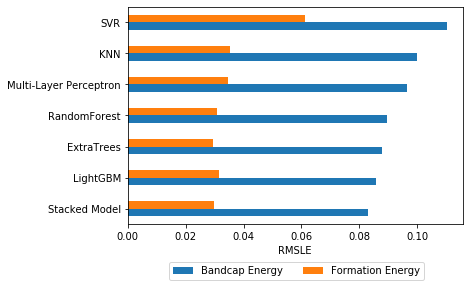

In [39]:
import pandas as pd
from matplotlib.pyplot import *

new = pd.read_csv("results.csv", delimiter=",").drop("Unnamed: 0", axis=1)

fig, ax = subplots()
new.sort_values(by="Bandcap Energy").plot.barh(x='Model', ax=ax)
ax.set_xlabel("RMSLE")
ax.set_ylabel("")
ax.legend( bbox_to_anchor=(0.9, -0.15), ncol=2)
plt.savefig("models.png", dpi=800,bbox_inches="tight")